# time-series-basics-exploring-traditional-ts.ipynbで得た知見を今回のコンペに適用してみる

# インポート

In [48]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データ読み込み

In [2]:
sales_history_df = pd.read_csv('./inputs/sales_history.csv')
category_names_df = pd.read_csv('./inputs/category_names.csv')
item_categories_df = pd.read_csv('./inputs/item_categories.csv')

In [3]:
sales_history_addfeature_df = pd.read_pickle('./inputs/sales_history_addfeature1.pickle')
item_categories_df = pd.read_pickle('./inputs/item_categories_addname')
test_df = pd.read_csv('./inputs/test.csv')

In [8]:
train_merged_data = pd.read_pickle('./inputs/train_merged_data.pickle')

In [4]:
train = sales_history_addfeature_df.copy()
test = test_df.copy()

In [11]:
train_merged_data.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,holiday,holiday_cat,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,月ブロック,month_cos,month_sin,weekday_cos,weekday_sin,day_cos,day_sin,売上金額,商品価格_is_0
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,420.0,0
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,420.0,0
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,420.0,0
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,250.0,0
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,250.0,0


In [15]:
# 必要な指標を月次レベルに集約します


monthly_sales=train_merged_data.groupby(['月ブロック', '店舗ID', '商品ID'])["日付","商品価格","売上個数"].agg({"日付":["min",'max'],"商品価格":"mean","売上個数":"sum"})

In [16]:
# take a peak
monthly_sales.head(20)

日付                   商品価格  売上個数
                          min        max        mean   sum
月ブロック 店舗ID 商品ID                                           
0     0    1000001 2018-01-06 2018-01-28  420.000000   6.0
           1000002 2018-01-03 2018-01-21  250.000000   2.0
           1000004 2018-01-17 2018-01-17  120.000000   1.0
           1000005 2018-01-04 2018-01-27  220.000000   8.0
           1000006 2018-01-04 2018-01-12  190.000000   2.0
           1000007 2018-01-03 2018-01-03  250.000000   1.0
           1000008 2018-01-04 2018-01-28  190.000000   4.0
           1000009 2018-01-07 2018-01-07  250.000000   1.0
           1000012 2018-01-06 2018-01-26  146.666667   3.0
           1000013 2018-01-02 2018-01-02  420.000000   1.0
           1000014 2018-01-26 2018-01-26  250.000000   1.0
           1000015 2018-01-04 2018-01-04  110.000000   1.0
           1000016 2018-01-16 2018-01-16  170.000000   1.0
           1000017 2018-01-01 2018-01-17  224.000000   5.0
           1000019 2018-01-15 2018-01-15  340.000000   1.0
           1000020 2018-01-29 2018-01-29  130.000000   1.0
           1000021 2018-01-16 2018-01-30  505.555556  26.0
           1000022 2018-01-04 2018-01-27  156.666667   3.0
           1000023 2018-01-12 2018-01-20  190.000000   2.0
           1000024 2018-01-20 2018-01-20  250.000000   1.0

In [19]:
# number of items per cat 
x=item_categories_df.groupby(['商品カテゴリ名']).count()
x=x.sort_values(by='商品ID',ascending=False)
x=x.iloc[0:10].reset_index()
x

,商品カテゴリ名,商品ID,商品カテゴリID
0,映画 - DVD,2733,2733
1,音楽 - その他,1379,1379
2,映画 - ブルーレイ,1049,1049
3,PCゲーム - 通常版,456,456
4,ゲーム - ゲーム機C,383,383
5,音楽 - レコード,354,354
6,ギフト - フィギュア,304,304
7,本 - オーディオブック_タイプA,281,281
8,ゲーム - ゲーム機B,267,267
9,音楽 - CD,259,259


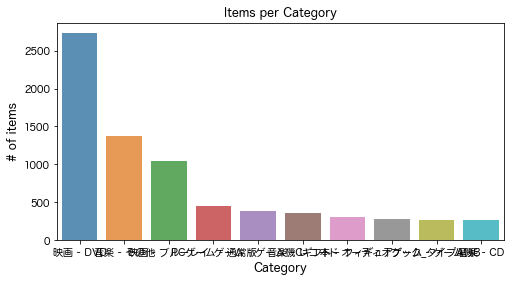

In [21]:
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.商品カテゴリ名, x.商品ID, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Single series

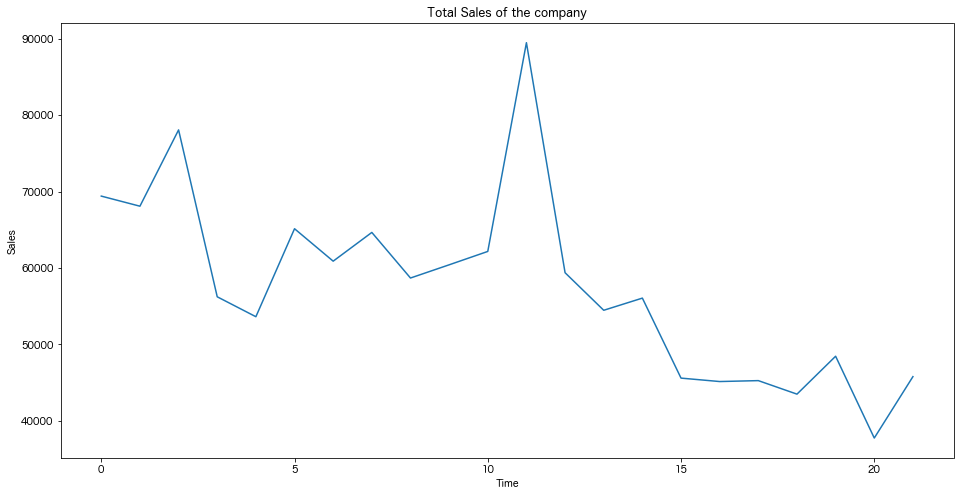

In [23]:
#ts
ts=train_merged_data.groupby(["月ブロック"])["売上個数"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [24]:
ts

月ブロック
0     69404.0
1     68082.5
2     78069.0
3     56226.0
4     53618.0
5     65134.5
6     60889.0
7     64649.5
8     58682.5
9     60410.5
10    62162.0
11    89483.5
12    59377.0
13    54461.0
14    56053.0
15    45582.0
16    45134.0
17    45254.0
18    43485.5
19    48446.0
20    37740.0
21    45775.0
Name: 売上個数, dtype: float64

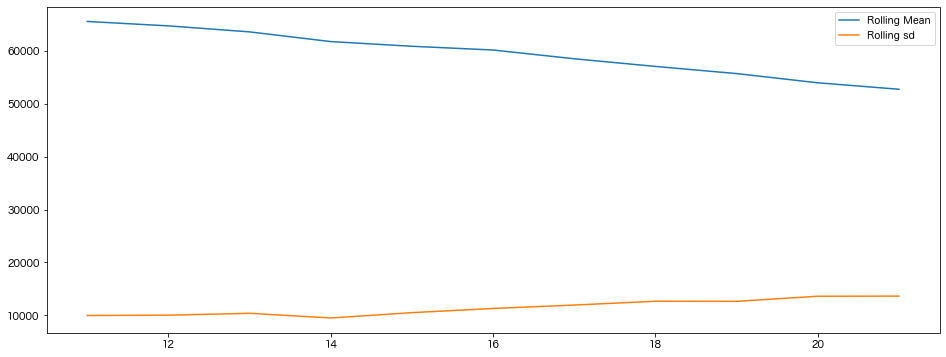

In [25]:
#pandasで窓関数を適用するrollingを使って移動平均などを算出
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**簡単な観察**  
明らかな「季節性」（例：1年のある時期のピーク売上）と減少する「傾向」があります。

トレンド、季節性、残差にすばやく分解して確認しましょう。

In [27]:
ts

月ブロック
0     69404.0
1     68082.5
2     78069.0
3     56226.0
4     53618.0
5     65134.5
6     60889.0
7     64649.5
8     58682.5
9     60410.5
10    62162.0
11    89483.5
12    59377.0
13    54461.0
14    56053.0
15    45582.0
16    45134.0
17    45254.0
18    43485.5
19    48446.0
20    37740.0
21    45775.0
Name: 売上個数, dtype: float64

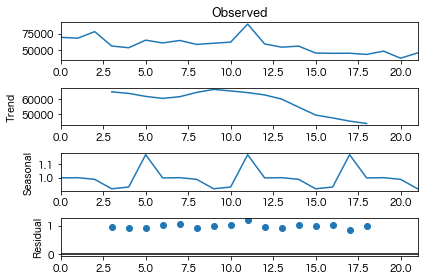

In [28]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=6,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

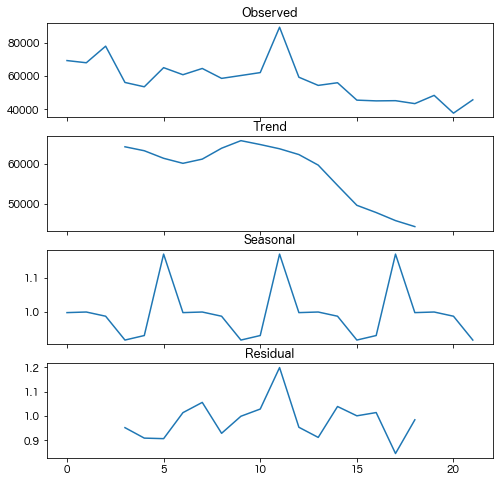

In [35]:
# 時系列データを傾向変動・季節変動・残差に分解する
decompose_result = sm.tsa.seasonal_decompose(ts.values,freq=6,
                                             # 乗法モデルを仮定する
                                             model='multiplicative')

# これでもグラフが描ける
# decompose_result.plot()

# 描画する領域を用意する
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.show()

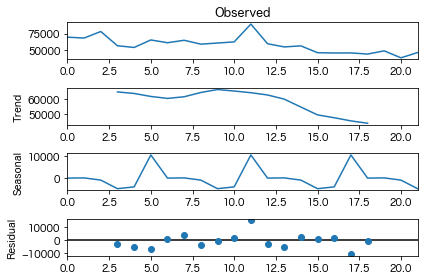

In [36]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=6,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

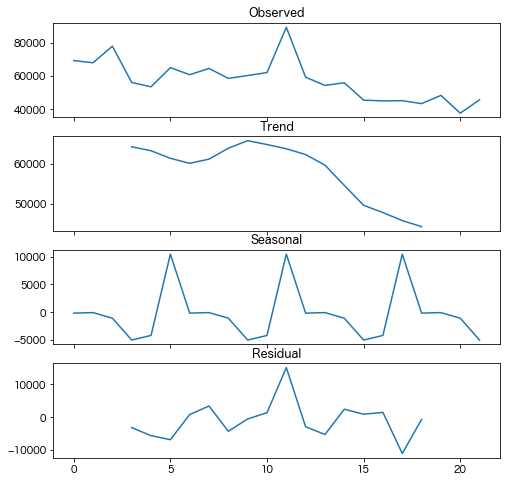

In [37]:
# 時系列データを傾向変動・季節変動・残差に分解する
decompose_result = sm.tsa.seasonal_decompose(ts.values,freq=6,
                                             # 乗法モデルを仮定する
                                             model='additive')

# これでもグラフが描ける
# decompose_result.plot()

# 描画する領域を用意する
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.show()

加法モデルを想定すると、次のように書くことができます。


> yt=St+Tt+Et 

ここで、ytは期間tのデータ、Stは期間tの季節成分、Ttは期間ttの傾向サイクル成分、Etは期間tの剰余（または不規則または誤差）成分です。乗法モデルの場合も同様です。

> yt=St  x Tt x Et 

## 定常性:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

定常性とは、系列の時不変を指します。 （ie）時系列の2つのポイントは、方向（順方向/逆方向）ではなく、それらがどれだけ離れているかによってのみ相互に関連しています。

時系列が定常である場合、モデル化が容易になる可能性があります。 統計モデリング手法では、時系列が静止していると想定または必要です。

定常性をチェックするために使用できる複数のテストがあります。
* ADF（拡張ディッキーフラー検定）
* KPSS
* PP（フィリップス-ペロン検定）

最も一般的に使用されているADFを実行してみましょう。

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)



In [40]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.387002
p-value                         0.145439
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [41]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

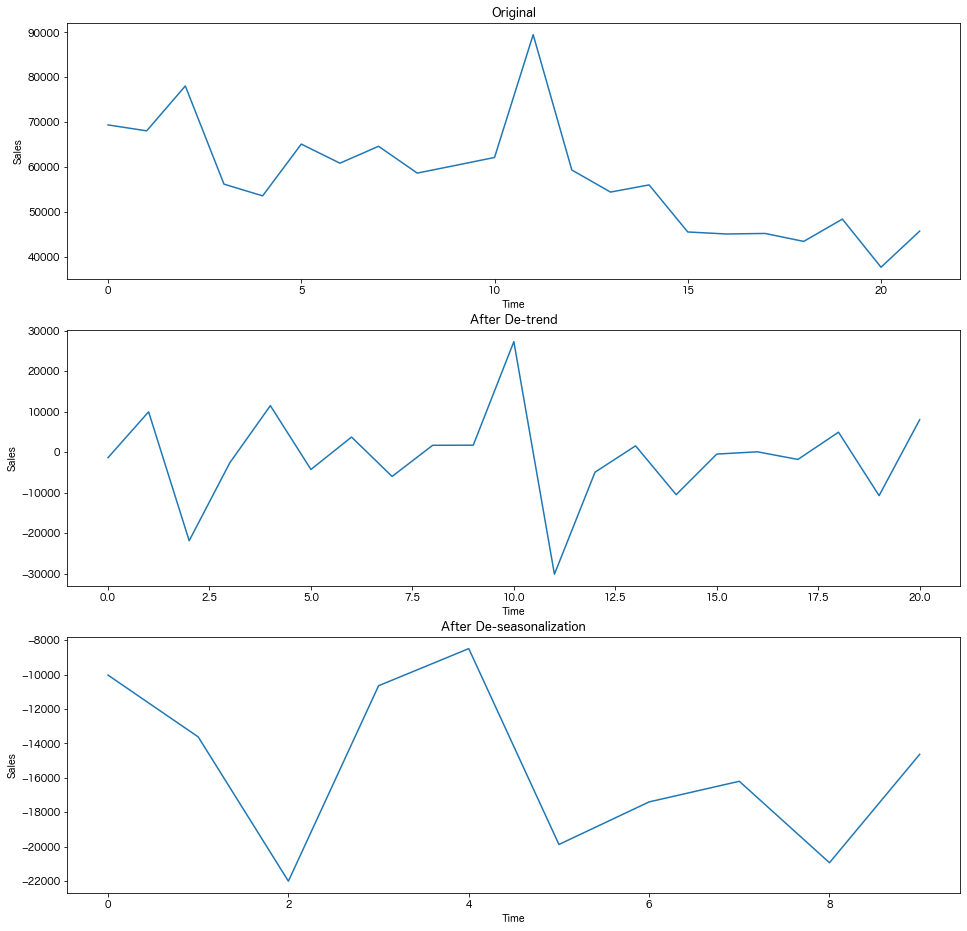

In [42]:
ts=train_merged_data.groupby(["月ブロック"])["売上個数"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [44]:
new_ts

0   -10027.0
1   -13621.5
2   -22016.0
3   -10644.0
4    -8484.0
5   -19880.5
6   -17403.5
7   -16203.5
8   -20942.5
9   -14635.5
dtype: float64

In [43]:
# 季節性がなくなった後、定常性を再度テストします
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -3.304061
p-value                        0.014698
#Lags Used                     3.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


### 変換後、DF検定のp値は5％以内に十分収まります。 したがって、シリーズの定常性を仮定できます

上で定義した逆変換関数を使用して、元の系列を簡単に戻すことができます。

それでは、予測を立てましょう。

# AR、MA、およびARMAモデル：
TL：モデルのDRバージョン：

MA-シリーズの次の値は、前のn個の値の平均の関数です
AR-次の値のエラー（平均の差）は、前のn個の値のエラーの関数です
ARMA-両方の混合物。

では、ARプロセスとMAプロセスのどちらの時系列かをどのように確認しますか？

確認してみましょう！

In [49]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

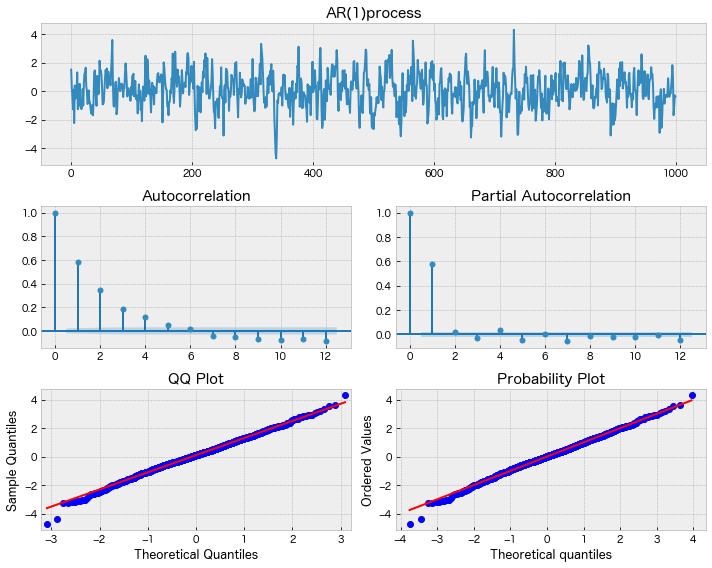

In [50]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

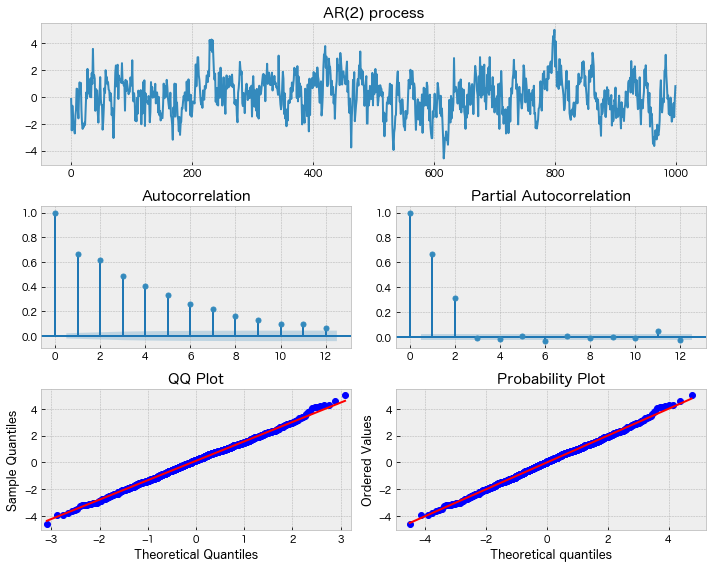

In [51]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

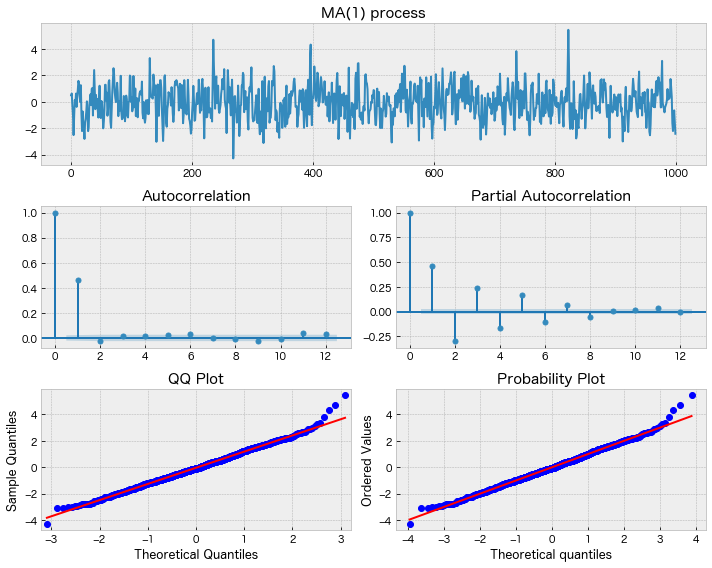

In [52]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

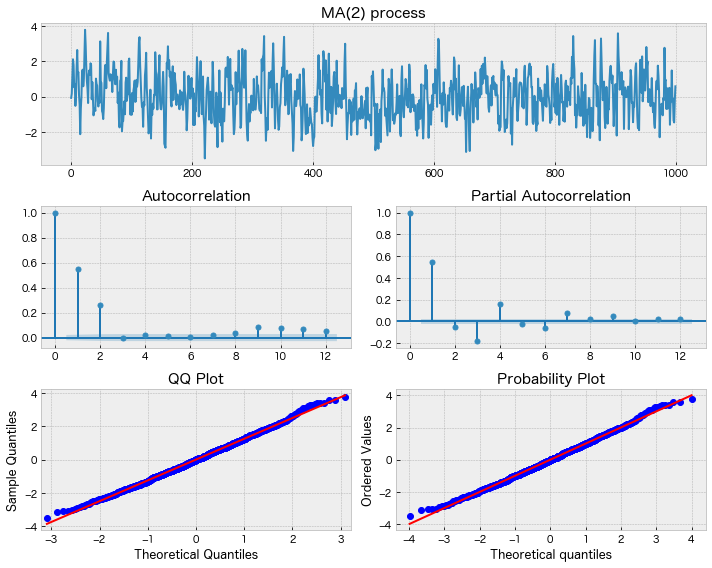

In [53]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

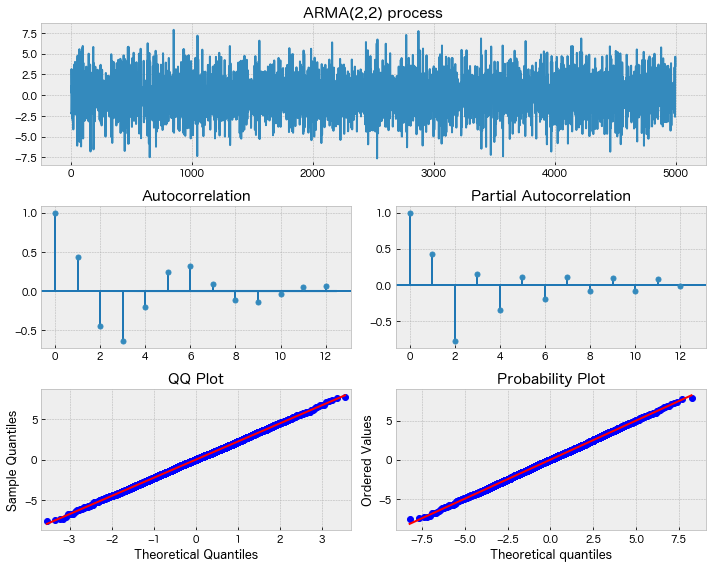

In [54]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## 今、物事は少しぼんやりします。 そのあまり明確/単純ではありません。

上記のプロットの気の利いた要約：

AACF形状| 示されたモデル|
-| -|
指数関数的、ゼロに減衰| 自己回帰モデル。 偏自己相関プロットを使用して、自己回帰モデルの次数を特定します。
正と負を交互に繰り返し、自己回帰モデルをゼロに減衰させます。 | 偏自己相関プロットを使用して、順序を特定します。 |
1つ以上のスパイク、残りは本質的にゼロです| 移動平均モデル、プロットがゼロになる場所によって識別される順序。 |
崩壊、いくつかの遅れの後に始まります| 自己回帰と移動平均の混合（ARMA）モデル。 |
すべてゼロまたはゼロに近い| データは本質的にランダムです。 |
一定の間隔で高い値| 季節的な自己回帰項を含めます。 |
ゼロへの減衰なし| シリーズは静止していません|


## 体系的なアプローチを使用して、ARプロセスとMAプロセスの順序を見つけましょう。

In [55]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03325D+00    |proj g|=  1.95259D-01

At iterate    5    f=  1.80549D+00    |proj g|=  3.23519D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6      7      1     0     0   0.000D+00   1.805D+00
  F =   1.8054887272095974     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74163D+00    |proj g|=  1.61497D-01

At iterate    5    f=  1.58376D+00    |proj g|=  6.02161D-03

At iterate   10    f=  1.58351D+00    |proj g|=  6.66134D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   2.220D-08   1.584D+00
  F =   1.5835099668300090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13135D+00    |proj g|=  6.16840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      7      1     0     0   0.000D+00   2.131D+00
  F =   2.1313463682897287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80812D+00    |proj g|=  5.76036D-02

At iterate    5    f=  1.77662D+00    |proj g|=  3.60378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   4.441D-08   1.777D+00
  F =   1.7766204391074385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00911D+00    |proj g|=  3.32563D-01

At iterate    5    f=  1.62836D+00    |proj g|=  2.37495D-02

At iterate   10    f=  1.61722D+00    |proj g|=  1.42109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   4.441D-08   1.617D+00
  F =   1.6172214226658335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82762D+00    |proj g|=  5.61018D-01

At iterate    5    f=  1.70109D+00    |proj g|=  3.58134D-02

At iterate   10    f=  1.65556D+00    |proj g|=  2.20113D-02

At iterate   15    f=  1.65412D+00    |proj g|=  5.81535D-05

At iterate   20    f=  1.65410D+00    |proj g|=  2.26572D-03

At iterate   25    f=  1.65404D+00    |proj g|=  2.08611D-04

At iterate   30    f=  1.65404D+00    |proj g|=  4.72955D-06



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  1.65404D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     59      1     0     0   8.882D-08   1.654D+00
  F =   1.6540370292629609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66044D+00    |proj g|=  6.64979D-04

At iterate    5    f=  1.66044D+00    |proj g|=  6.72795D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61929D+00    |proj g|=  3.64772D-02

At iterate    5    f=  1.59412D+00    |proj g|=  1.71293D-02

At iterate   10    f=  1.59389D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   0.000D+00   1.594D+00
  F =   1.5938902273172770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53176D+00    |proj g|=  2.54556D-03

At iterate    5    f=  1.53167D+00    |proj g|=  1.81943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   0.000D+00   1.532D+00
  F =   1.5316681089893485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53210D+00    |proj g|=  6.89635D-03

At iterate    5    f=  1.53168D+00    |proj g|=  1.20648D-03

At iterate   10    f=  1.53166D+00    |proj g|=  4.63629D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   2.220D-08   1.532D+00
  F =   1.5316648383821263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53194D+00    |proj g|=  5.62124D-03

At iterate    5    f=  1.53167D+00    |proj g|=  2.50933D-04

At iterate   10    f=  1.53166D+00    |proj g|=  6.63691D-05

At iterate   15    f=  1.53166D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   2.220D-08   1.532D+00
  F =   1.5316647541079775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64991D+00    |proj g|=  6.53455D-04

At iterate    5    f=  1.64991D+00    |proj g|=  7.01661D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   0.000D+00   1.650D+00
  F =   1.6499108619947844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57703D+00    |proj g|=  4.88958D-02

At iterate    5    f=  1.55719D+00    |proj g|=  2.56870D-02

At iterate   10    f=  1.55429D+00    |proj g|=  7.01883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   8.882D-08   1.554D+00
  F =   1.5542887325103614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53210D+00    |proj g|=  7.41518D-03

At iterate    5    f=  1.53167D+00    |proj g|=  4.49885D-04

At iterate   10    f=  1.53166D+00    |proj g|=  8.10463D-06

At iterate   15    f=  1.53166D+00    |proj g|=  1.13420D-04


 This problem is unconstrained.



At iterate   20    f=  1.53166D+00    |proj g|=  3.40039D-04

At iterate   25    f=  1.53165D+00    |proj g|=  1.08300D-03

At iterate   30    f=  1.53162D+00    |proj g|=  2.21938D-03

At iterate   35    f=  1.53154D+00    |proj g|=  1.94895D-03

At iterate   40    f=  1.53143D+00    |proj g|=  2.17002D-03

At iterate   45    f=  1.53139D+00    |proj g|=  4.03921D-04

At iterate   50    f=  1.53139D+00    |proj g|=  1.57652D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     54     90      2     0     0   4.441D-08   1.531D+00
  F =   1.5313923863017447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53203D+00    |proj g|=  6.71798D-03

At iterate    5    f=  1.53166D+00    |proj g|=  3.11462D-04

At iterate   10    f=  1.53165D+00    |proj g|=  5.00489D-05


 This problem is unconstrained.



At iterate   15    f=  1.53165D+00    |proj g|=  1.20985D-03

At iterate   20    f=  1.53160D+00    |proj g|=  1.44880D-03

At iterate   25    f=  1.53144D+00    |proj g|=  2.17708D-03

At iterate   30    f=  1.53133D+00    |proj g|=  5.52380D-04

At iterate   35    f=  1.53127D+00    |proj g|=  6.65401D-04

At iterate   40    f=  1.53126D+00    |proj g|=  4.41425D-05

At iterate   45    f=  1.53126D+00    |proj g|=  1.99840D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     64      1     0     0   4.441D-08   1.531D+00
  F =   1.5312629659557906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58543D+00    |proj g|=  1.22842D-03

At iterate    5    f=  1.58543D+00    |proj g|=  4.86278D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   0.000D+00   1.585D+00
  F =   1.5854292725155319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   2.220D-08   1.541D+00
  F =   1.5413918725565929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53230D+00    |proj g|=  5.33742D-03

At iterate    5    f=  1.53174D+00    |proj g|=  7.90035D-04

At iterate   10    f=  1.53167D+00    |proj g|=  1.01814D-03


 This problem is unconstrained.



At iterate   15    f=  1.53166D+00    |proj g|=  3.33067D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   6.661D-08   1.532D+00
  F =   1.5316645747132100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53223D+00    |proj g|=  7.75444D-03

At iterate    5    f=  1.53166D+00    |proj g|=  1.30416D-03

At iterate   10    f=  1.53165D+00    |proj g|=  1.94245D-04

At iterate   15    f=  1.53165D+00    |proj g|=  2.77711D-04

At iterate   20    f=  1.53163D+00    |proj g|=  2.09261D-03

At iterate   25    f=  1.53152D+00    |proj g|=  2.50362D-03

At iterate   30    f=  1.53136D+00    |proj g|=  2.25631D-03

At iterate   35    f=  1.53127D+00    |proj g|=  1.95968D-03

At iterate   40    f=  1.53123D+00    |proj g|=  1.05693D-04

At iterate   45    f=  1.53123D+00    |proj g|=  6.39488D-06

At iterate   50    f=  1.53123D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53172D+00    |proj g|=  4.89719D-03

At iterate    5    f=  1.53143D+00    |proj g|=  3.97038D-04

At iterate   10    f=  1.53142D+00    |proj g|=  8.58824D-04

At iterate   15    f=  1.53131D+00    |proj g|=  1.45690D-03

At iterate   20    f=  1.53128D+00    |proj g|=  1.52587D-03

At iterate   25    f=  1.53127D+00    |proj g|=  6.62714D-04

At iterate   30    f=  1.53126D+00    |proj g|=  3.03113D-04

At iterate   35    f=  1.53125D+00    |proj g|=  1.46800D-03

At iterate   40    f=  1.53125D+00    |proj g|=  6.53033D-05

At iterate   45    f=  1.53125D+00    |proj g|=  4.57190D-05

At iterate   50    f=  1.53125D+00    |proj g|=  1.62093D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

## シミュレートされたプロセスの順序をARMA（2,2）として正しく識別しました。

### 販売時系列に使用しましょう。

In [56]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12060D+01    |proj g|=  4.80211D-01

At iterate    5    f=  1.06273D+01    |proj g|=  8.51514D-03

At iterate   10    f=  1.06230D+01    |proj g|=  2.57749D-04

At iterate   15    f=  1.06229D+01    |proj g|=  7.99361D-06

At iterate   20    f=  1.06229D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1     20     22      1     0     0   0.000D+00   1.062D+01
  F =   10.622913294519465     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [25]:
# Simply use best_mdl.predict() to predict the next values

In [60]:
# adding the dates to the Time-series as index
ts=train_merged_data.groupby(["月ブロック"])["売上個数"].sum()
ts.index=pd.date_range(start = '2018-01-01',end='2019-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,売上個数
0,2018-01-01,69404.0
1,2018-02-01,68082.5
2,2018-03-01,78069.0
3,2018-04-01,56226.0
4,2018-05-01,53618.0


# Prophet: 

最近Facebookの調査によってオープンソース化されました。 これは非常に有望なツールであり、イライラするフラットラインに対する非常に便利で迅速なソリューションであることがよくあります：P

![FLATLINE](https://i.stack.imgur.com/fWzyX.jpg)

確かに、適切な前処理とパラメータの注意深い調整があれば、上記のグラフは発生しないと主張することができます。

しかし、真実は、私たちのほとんどがそれを実現するための忍耐力も専門知識も持っていないということです。

また、ほとんどの実際的なシナリオでは、予測する必要のある時系列が多数あるという事実もあります。例：このコンテスト。ストアの翌月の売上を予測する必要があります。アイテムレベルの組み合わせは数千に及ぶ可能性があります。（つまり、数千のパラメータを予測します。

もう1つの優れた機能は、一般的なsklearn構文に従うことです。

本質的に、預言者の手順は、4つの主要なコンポーネントを持つ加法回帰モデルです。
* 区分的線形またはロジスティック成長曲線の傾向。 Prophetは、データから変化点を選択することにより、傾向の変化を自動的に検出します。
* フーリエ級数を使用してモデル化された年間季節成分。
* ダミー変数を使用した毎週の季節コンポーネント。
* ユーザーが提供する重要な休日のリスト。

**Resources for learning more about prophet:**
* https://www.youtube.com/watch?v=95-HMzxsghY
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://research.fb.com/prophet-forecasting-at-scale/
* https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [62]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.



Initial log joint probability = -55.2066
Iteration  1. Log joint probability =    16.2308. Improved by 71.4374.
Iteration  2. Log joint probability =    27.1686. Improved by 10.9378.
Iteration  3. Log joint probability =     53.781. Improved by 26.6124.
Iteration  4. Log joint probability =    74.1488. Improved by 20.3678.
Iteration  5. Log joint probability =    87.6454. Improved by 13.4967.
Iteration  6. Log joint probability =    96.9033. Improved by 9.25782.
Iteration  7. Log joint probability =    96.9053. Improved by 0.00205948.
Iteration  8. Log joint probability =    96.9058. Improved by 0.00051487.
Iteration  9. Log joint probability =    96.9078. Improved by 0.00200192.
Iteration 10. Log joint probability =    96.9088. Improved by 0.00100096.
Iteration 11. Log joint probability =    96.9234. Improved by 0.0146061.
Iteration 12. Log joint probability =    96.9307. Improved by 0.00730295.
Iteration 13. Log joint probability =    96.9332. Improved by 0.00246216.
Iteration 14. L

SystemError: <class 'stanfit4anon_model_dfdaf2b8ece8a02eb11f050ec701c0ec_400299896121763349.PyStanHolder'> returned a result with an error set

In [63]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

KeyError: 'k'

In [64]:
model.plot(forecast)

NameError: name 'forecast' is not defined

In [65]:
model.plot_components(forecast)

NameError: name 'forecast' is not defined

Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

## UCM:

Unobserved Components Model. The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.

Unfortunately, I could not find a good package/code that can perform this model in Python :( 

R version of UCM: https://bicorner.com/2015/12/28/unobserved-component-models-in-r/

# Hierarchical time series:

The [Forecasting: principles and practice](https://www.otexts.org/fpp/9/4) , is the ultimate reference book for forecasting by Rob J Hyndman.

He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.

![](https://www.otexts.org/sites/default/files/resize/fpp/images/hts1-550x274.png)

Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.

### Bottom up approach:
* Predict all the base level series using any method, and then just aggregate it to the top.
* Advantages: Simple , No information is lost due to aggregation.
* Dis-advantages: Lower levels can be noisy

### Top down approach:
* Predict the top level first. (Eg: predict total sales first)
* Then calculate **weights** that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales 
* There are different ways of arriving at the "weights". 
    * **Average Historical Proportions** - Simple average of the item's contribution to sales in the past months
    * **Proportion of historical averages** - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
    * **Forecasted Proportions** - Predict the proportion in the future using changes in the past proportions
* Use these weights to calcuate the base -forecasts and other levels

### Middle out:
* Use both bottom up and top down together.
* Eg: Consider our problem of predicting store-item level forecasts.
    * Take the middle level(Stores) and find forecasts for the stores
    * Use bottoms up approach to find overall sales
    * Dis-integrate store sales using proportions to find the item-level sales using a top-down approach
    
### Optimal combination approach:
* Predict for all the layers independently
* Since, all the layers are independent, they might not be consistent with hierarchy
    * Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store  or as Hyndman puts it “aggregate consistent”
* Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy


### Enough with the theory. Lets start making forecasts! :P
The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a **million** individual time-series(item-store combinations) that we need to predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here: 
* Not all stores sell all items
* What happens when a new product is introduced? 
* What if a product is removed off the shelves?

In [31]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

In [32]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

In [33]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    

~16s for 10 predictions. We need a million predictions. This would not work out.

# Middle out:
Let's predict for the store level

In [34]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

In [35]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

In [36]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [37]:
predictions_unknown=predictions[-1]
predictions_unknown

## Under construction...........

### Unconventional techniques: converting TS into a regression problem

### Dealing with Hierarchy
### Codes for top down, optimal ,etc



## Foot-notes:

I'm not a stats major, so please do let me know in the comments if you feel that I've left out any important technique or if there was any mistake in the content.

I plan to add another kernel about Time-series here which would be about adapting the open-source solutions from the recent time-series competitions ( Favorita, Recruit,etc. ) to this playground dataset.

Do leave a comment/upvote :) 